## IMDB

In [1]:
from keras.callbacks import EarlyStopping
from keras.datasets import imdb
from keras import models, layers, optimizers, losses, metrics
from keras.utils import set_random_seed
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

set_random_seed(0)
np.random.seed(0)

In [2]:
#The argument num_words=10000 means you’ll only keep the top 10k most frequently occurring words in the training data.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

#looking at the training set
print(train_data[0])
print(train_labels[0]) #a 0-label stands for negative and 1-label stands for positive

#because you’re restricting yourself to the top 10k most frequent words, no word index will exceed 10k
print(max([max(sequence) for sequence in train_data]))

#decoding a review
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
#the next line decodes the first review. Note that the indices are offset by 3
#because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_review)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1
9999
? this film was just brilliant casting location scene

**Preparação dos dados**

Não é possível usar listas de inteiros em uma rede neural. É necessário converter as listas em tensores. Existem duas maneiras de se fazer isso:
- Preencher suas listas para que todas tenham o mesmo comprimento, transformá-las em um tensor de inteiros com forma (amostras, índices_de_palavras) e, em seguida, usar como primeira camada em sua rede uma camada capaz de lidar com esses tensores de inteiros (a camada `Embedding`, que abordaremos em detalhes mais tarde).
- Codificar suas listas usando *one-hot encoding* para transformá-las em vetores de 0s e 1s. Isso significaria, por exemplo, transformar a sequência [3, 5] em um vetor de 10.000 dimensões, que seria todo de 0s, exceto nos índices 3 e 5, que seriam 1s. Então, você poderia usar como a primeira camada em sua rede uma camada `Dense`, capaz de lidar com vetor de dados de ponto flutuante.

Vamos seguir com a última solução para vetorizar os dados.

In [3]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print(x_train[0])

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

[0. 1. 1. ... 0. 0. 0.]


**Construindo a rede**

Os dados de entrada são vetores, e os rótulos são escalares (1s e 0s): esta é a configuração mais simples que você encontrará. Um tipo de rede que se sai bem nesse problema é uma pilha simples de camadas totalmente conectadas (`Dense`) com ativações `relu`: `Dense(16, activation='relu')`.

O argumento passado para cada camada Dense (16) é o número de unidades ocultas da camada. Uma *unidade oculta* é uma dimensão no espaço de representação da camada. Lembre-se de que cada camada `Dense` com ativação `relu` implementa a seguinte sequência de operações tensoriais:

`output = relu(dot(W, input) + b)`

Ter 16 unidades ocultas significa que a matriz de pesos `W` terá forma `(dimensão_de_entrada, 16)`: o produto escalar (`dot`) com `W` projetará os dados de entrada em um espaço de representação de 16 dimensões (e depois o vetor de viés `b` será adicionado e se aplicará a operação `relu`). Você pode entender intuitivamente a dimensionalidade do seu espaço de representação como "quanta liberdade você está permitindo que a rede tenha ao aprender representações internas". Ter mais unidades ocultas (um espaço de representação de maior dimensão) permite que sua rede aprenda representações mais complexas, mas torna a rede computacionalmente mais cara e pode levar a aprender padrões indesejados (padrões que melhorarão o desempenho nos dados de treinamento, mas não nos dados de teste).

Existem duas decisões-chave de arquitetura a serem tomadas sobre essa pilha de camadas `Dense`:
- Quantas camadas usar
- Quantas unidades ocultas escolher para cada camada

Na próxima aula, você aprenderá princípios formais para orientar na tomada dessas decisões. Por enquanto, terá que confiar em mim com a seguinte escolha de arquitetura:
- Duas camadas intermediárias com 16 unidades ocultas cada
- Uma terceira camada que produzirá a previsão escalar sobre o sentimento da resenha atual

As camadas intermediárias usarão `relu' como sua função de ativação, e a camada final usará uma função de ativação sigmóide para produzir uma probabilidade (uma pontuação entre 0 e 1, indicando a probabilidade de a amostra ter o alvo "1": a probabilidade da resenha ser positiva).

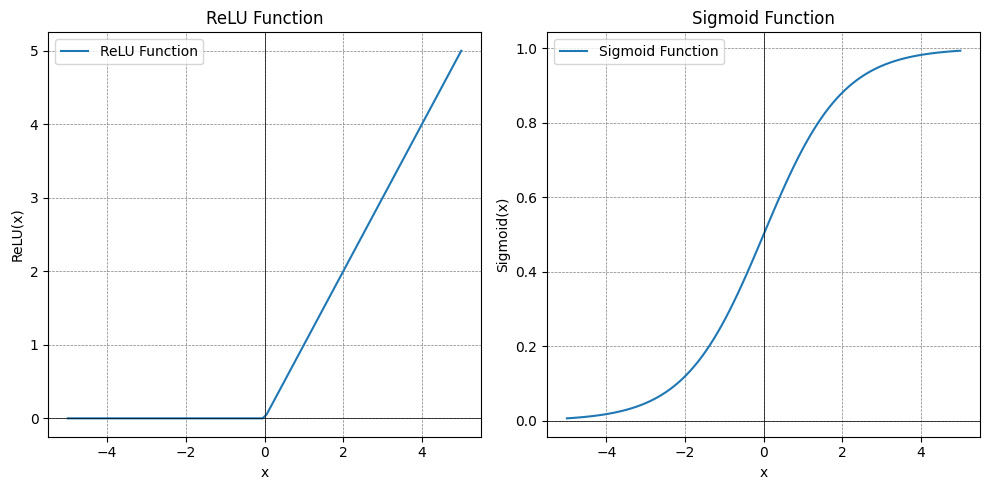

In [4]:
### printing the relu and the sigmoid functions

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-5, 5, 100)
y_relu = relu(x)
y_sigmoid = sigmoid(x)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y_relu, label='ReLU Function')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU Function')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
plt.plot(x, y_sigmoid, label='Sigmoid Function')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.title('Sigmoid Function')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [5]:
### The model definition
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Digressão: o que são funções de ativação e por que são necessárias?**

Sem uma função de ativação como `relu` (também chamada de *não-linearidade*), a camada `Dense` consistiria em duas operações lineares - um produto escalar e uma adição:

`output = dot(W, input) + b`

Assim, a camada só poderia aprender *transformações lineares* (transformações afins) dos dados de entrada: o espaço de hipóteses da camada seria o conjunto de todas as possíveis transformações lineares dos dados de entrada em um espaço de 16 dimensões. Tal espaço de hipóteses é muito restrito e não se beneficiaria de várias camadas de representações, pois uma pilha profunda de camadas lineares ainda implementaria uma operação linear: adicionar mais camadas não estenderia o espaço de hipóteses.

Para obter acesso a um espaço de hipóteses muito mais rico que se beneficiaria de representações profundas, é necessário uma não-linearidade ou função de ativação. `relu` é a função de ativação mais popular em aprendizado profundo, mas existem muitas outras opções, que têm nomes igualmente estranhos: `prelu`, `elu`, e assim por diante.

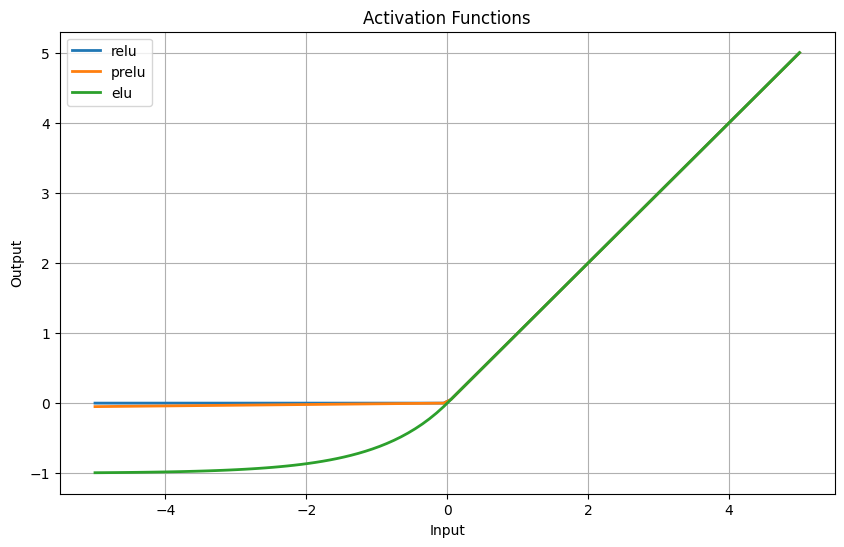

In [6]:
# Define the activation functions
def relu(x):
    return np.maximum(0, x)

def prelu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

# Generate x values
x_values = np.linspace(-5, 5, 100)

# Compute y values for each activation function
relu_values = relu(x_values)
prelu_values = prelu(x_values)
elu_values = elu(x_values)

# Plot the activation functions
plt.figure(figsize=(10, 6))
plt.plot(x_values, relu_values, label='relu', linewidth=2)
plt.plot(x_values, prelu_values, label='prelu', linewidth=2)
plt.plot(x_values, elu_values, label='elu', linewidth=2)

# Add labels and legend
plt.title('Activation Functions')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Por fim, você precisa escolher uma função de perda e um otimizador. Como você está lidando com um problema de classificação binária e a saída da sua rede é uma probabilidade (você encerra sua rede com uma camada de unidade única com ativação sigmóide), é melhor usar a perda `binary_crossentropy`. Não é a única escolha viável: você poderia usar, por exemplo, `mean_squared_error`. Mas a entropia cruzada geralmente é a melhor escolha quando lidamos com modelos que geram probabilidades. A *entropia cruzada* é uma quantidade da área da Teoria da Informação que mede a distância entre distribuições de probabilidade ou, neste caso, entre a distribuição verdadeira e suas previsões.

In [7]:
### Compiling the model

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Alternativamente, é possível customizar o otimizador e a função perda

In [8]:
### Configuring the optimizer
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
loss='binary_crossentropy',
metrics=['accuracy'])

In [9]:
### Using custom losses and metrics
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
loss=losses.binary_crossentropy,
metrics=[metrics.binary_accuracy])

**Validando a abordagem**

Para monitorar durante o treinamento a precisão do modelo em dados que nunca viu antes, você criará um conjunto de validação reservando 10k amostras do conjunto original de dados de treinamento.

In [10]:
### Setting aside a validation set

x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Agora você treinará o modelo por 20 épocas (20 iterações sobre todas as amostras nos tensores x_train e y_train), em lotes de 512 amostras. Ao mesmo tempo, você monitorará a perda e a precisão nas 10.000 amostras que reservou, fazendo isso ao passar os dados de validação como o argumento validation_data.

In [11]:
### Treinando o modelo

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.6772 - loss: 0.6088 - val_acc: 0.8659 - val_loss: 0.3984
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8906 - loss: 0.3412 - val_acc: 0.8844 - val_loss: 0.3094
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9193 - loss: 0.2476 - val_acc: 0.8891 - val_loss: 0.2834
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9380 - loss: 0.1934 - val_acc: 0.8881 - val_loss: 0.2771
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9503 - loss: 0.1607 - val_acc: 0.8866 - val_loss: 0.2811
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9589 - loss: 0.1360 - val_acc: 0.8837 - val_loss: 0.2880
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9688 - loss: 0.1128 - val_acc: 0.8838 - val_loss: 0.2994
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9744 - loss: 0.0964 - val_acc: 0.8838 - val_loss: 0.3120
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9820 - loss: 0.0786 - v

Observe que a chamada `model.fit()` retorna um objeto da classe `History`. Este objeto possui um membro `history`, que é um dicionário contendo dados sobre tudo que aconteceu durante o treinamento. Vamos examiná-lo:

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

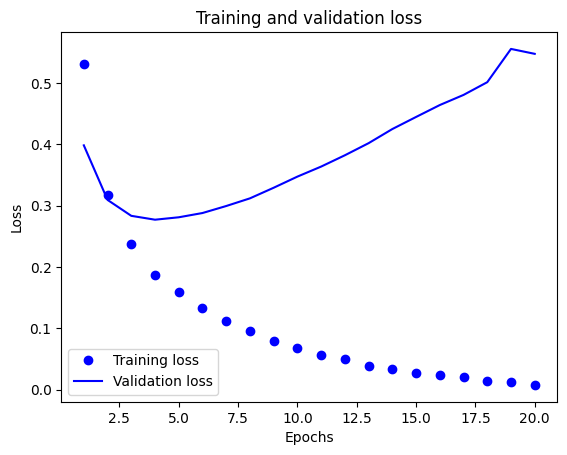

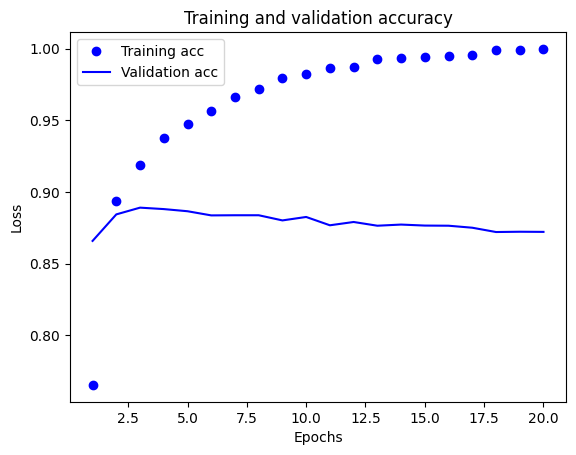

In [13]:
### Plotting the training and validation loss

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history.history['acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting the training and validation accuracy
plt.clf()
acc_values = history_dict['acc']
val_acc = history.history['val_acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Como se pode ver, a perda de treinamento diminui a cada época, e a precisão de treinamento aumenta a cada época. Isso é o que se esperaria ao executar a otimização por descida de gradiente - a quantidade que se está tentando minimizar deve ser menor a cada iteração. Mas esse não é o caso para a perda de validação e precisão: elas parecem atingir o pico na quarta época. Este é um exemplo do que avisamos anteriormente: um modelo que se sai melhor nos dados de treinamento não é necessariamente um modelo que se sairá melhor em dados que nunca viu antes. Em termos precisos, o que está ocorrendo é um **overfitting**: após a segunda época, está se otimizando demais para os dados de treinamento e acaba-se aprendendo representações específicas para esses dados de treinamento que não generalizam para dados fora do conjunto de treinamento.

Neste caso, para evitar o *overfitting*, poderíamos parar o treinamento após três épocas. Em geral, é possível usar uma variedade de técnicas para mitigar o overfitting, as quais abordaremos na próxima aula.

Vamos treinar uma nova rede do zero por quatro épocas e, em seguida, avaliá-la nos dados de teste.

In [14]:
### Retraining a model from scratch

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
print(results)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7310 - loss: 0.5717
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9012 - loss: 0.3035
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9232 - loss: 0.2283
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9319 - loss: 0.1951
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.8843 - loss: 0.2916
[0.2881070375442505, 0.8851600289344788]


Esta abordagem bastante ingênua alcança uma precisão de 88%. Com abordagens melhores, é possível conseguir se aproximar de 95%.

**Usando uma rede treinada para gerar previsões a partir de novos dados**

In [15]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step


array([[0.25832   ],
       [0.9999603 ],
       [0.9520606 ],
       ...,
       [0.17216097],
       [0.13558303],
       [0.62718666]], dtype=float32)

Como você pode ver, a rede está confiante para algumas amostras (0.99 ou mais, ou 0.01 ou menos), mas menos confiante para outras (0.6, 0.4).

# **Exercícios**

1. Você utilizou duas camadas `Dense`. Use uma ou três camadas e veja como isso afeta a precisão na validação e no teste.
2. Use camadas com mais unidades ocultas ou menos unidades ocultas: 32 unidades, 64 unidades, e assim por diante.
3. Use a função de perda `mse` em vez de `binary_crossentropy`.
4. Use a ativação `tanh` (uma ativação que era popular nos primeiros dias das redes neurais) em vez de `relu`.

In [16]:
def pad_shorter_history(history, max_epochs):
    """Uses np.pad to add np.nan to shorter histories"""
    padded_history = {}
    for key, values in history.items():
        padded_history[key] = np.pad(values, (0, max_epochs - len(values)), mode='constant', constant_values=np.nan)
    return padded_history

In [17]:
def plot_stats_comparason(models: list, x_test, y_test, model_names: list=None, save_path: str=None):
    """Print the classification report and plot the confusion matrix for N models"""

    # Create the subplots for the confusion matrices with 2 columns
    rows = len(models) // 2 + len(models) % 2
    # columns = 2 if len(models) > 1 else 1
    fig, ax = plt.subplots(rows, 2, figsize=(10, 5 * rows))

    for i, model in enumerate(models):
        model_name = model_names[i] if model_names else f'Model {i + 1}'
        print(model_name)
        y_pred = model.predict(x_test)

        # Classification reports
        print(classification_report(y_test, y_pred > 0.5))

        # Confusion matrices
        cm = confusion_matrix(y_test, y_pred > 0.5)

        ax[i].imshow(cm, cmap='Blues', aspect='auto')
        ax[i].set_title(model_name)
        ax[i].set_xlabel("Predicted")
        ax[i].set_ylabel("True")
        ax[i].set_xticks([0, 1])
        ax[i].set_xticklabels(["Negative", "Positive"])
        ax[i].set_yticks([0, 1])
        ax[i].set_yticklabels(["Negative", "Positive"])
        for _i in range(2):
            for _j in range(2):
                ax[i].text(_j, _i, cm[_i, _j], ha='center', va='center', color='black')
    
    # Remove the last subplot if the number of models is odd
    if len(models) % 2 != 0:
        fig.delaxes(ax.flatten()[-1])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [18]:
# Funções de apoio
def plot_train_val_loss(*histories, history_labels: list=None, save_path=None, loss_labels=None):
    """Plots the training and validation loss from N histories"""
    set_random_seed(0)
    np.random.seed(0)

    # Padding shorter history with np.nan to plot them together
    max_epochs = max([len(history.history['loss']) for history in histories])
    histories = [pad_shorter_history(history.history.copy(), max_epochs) for history in histories]

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    colors = plt.cm.rainbow(np.linspace(0, 1, len(histories)))
    np.random.shuffle(colors)

    for i, history in enumerate(histories):
        history_dict = history
        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        n_epochs = len(loss_values)

        best_epoch = np.nanargmin(val_loss_values)
        best_valid_loss = val_loss_values[best_epoch]
        epochs = range(1, len(loss_values) + 1)

        # Labels
        hist_label = history_labels[i] if history_labels else f"{i + 1}"
        best_model_stats = (f'Melhor modelo {hist_label}\népoca={best_epoch + 1}\n'
        f'loss={best_valid_loss:.2f}\nval_acc={history_dict["val_accuracy"][best_epoch]:.2f}')

        # Plotting loss lines
        ax.plot(epochs, loss_values, "--", linewidth=2, label=f"Training set {hist_label}", c=colors[i])
        ax.plot(epochs, val_loss_values, "-", linewidth=3, label=f"Validation set {hist_label}", c=colors[i])
        # Marking the best epoch
        ax.plot(best_epoch+1, best_valid_loss, "o", c=colors[i])
        ax.plot([0, n_epochs], [best_valid_loss, best_valid_loss], "k:", linewidth=2)
        ax.annotate(best_model_stats,
                    xy=(best_epoch+1, best_valid_loss),
                    xytext=(best_epoch+1, best_valid_loss + 0.04),
                    ha="center",
                    arrowprops=dict(facecolor='black', shrink=0.05))

    ax.grid()
    ax.set_title('Training and validation loss')
    ax.set_xlabel('Épocas')
    ax.set_ylabel(f'{loss_labels[i] if loss_labels else "Categorical Crossentropy"} loss')
    ax.legend()
    # ax.axis([0, n_epochs, 0, 0.10])
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


## 1. Você utilizou duas camadas `Dense`. Use uma ou três camadas e veja como isso afeta a precisão na validação e no teste.

In [19]:
# A model with a single hidden layer
architecture_1layer = {
    'layers': [
        {'units': 16, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 1, 'activation': 'sigmoid'}
    ],
    'loss': 'binary_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [20]:
# A model with three hidden layers
architecture_3layers = {
    'layers': [
        {'units': 16, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 16, 'activation': 'relu'},
        {'units': 1, 'activation': 'sigmoid'}
    ],
    'loss': 'binary_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [21]:
def create_model(architecture, early_stopping_patience=3):
    """Creates a model from a given architecture and fits it to the training data"""
    set_random_seed(0)
    np.random.seed(0)
    model = models.Sequential()
        
    for i, layer in enumerate(architecture['layers']):
        if i == 0:
            model.add(layers.Dense(**layer))
        else:
            model.add(layers.Dense(**layer))

    model.compile(optimizer=architecture['optimizer'],
                    loss=architecture['loss'],
                    metrics=architecture['metrics'])
    
    return model

In [22]:
model_1layer = create_model(architecture_1layer)
model_3layers = create_model(architecture_3layers)

In [23]:
def fit_model(model, x_train, y_train, x_val, y_val, epochs=20, batch_size=512, early_stopping_patience=3):
    set_random_seed(0)
    np.random.seed(0)
    early_stopping = [EarlyStopping(monitor='val_loss', patience=early_stopping_patience)]
    
    return model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val), callbacks=early_stopping)

In [24]:
# Fit model with one layer
history_1layer = fit_model(model_1layer, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7083 - loss: 0.5906 - val_accuracy: 0.8622 - val_loss: 0.4046
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8901 - loss: 0.3569 - val_accuracy: 0.8801 - val_loss: 0.3323
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9160 - loss: 0.2759 - val_accuracy: 0.8854 - val_loss: 0.2996
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9275 - loss: 0.2292 - val_accuracy: 0.8896 - val_loss: 0.2848
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9387 - loss: 0.1979 - val_accuracy: 0.8878 - val_loss: 0.2796
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9471 - loss: 0.1743 - val_accuracy: 0.8858 - val_loss: 0.2787
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9525 - loss: 0.1563 - val_accuracy: 0.8822 - val_loss: 0.2818
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9599 - loss: 0.1405 - val_accuracy: 0.8828 - 

In [25]:
# Fit model with three layers
history_3layers = fit_model(model_3layers, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6772 - loss: 0.6088 - val_accuracy: 0.8659 - val_loss: 0.3984
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8906 - loss: 0.3412 - val_accuracy: 0.8844 - val_loss: 0.3094
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9193 - loss: 0.2476 - val_accuracy: 0.8891 - val_loss: 0.2834
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9380 - loss: 0.1934 - val_accuracy: 0.8881 - val_loss: 0.2771
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9503 - loss: 0.1607 - val_accuracy: 0.8866 - val_loss: 0.2811
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9589 - loss: 0.1360 - val_accuracy: 0.8837 - val_loss: 0.2880
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9688 - loss: 0.1128 - val_accuracy: 0.8838 - val_loss: 0.2994


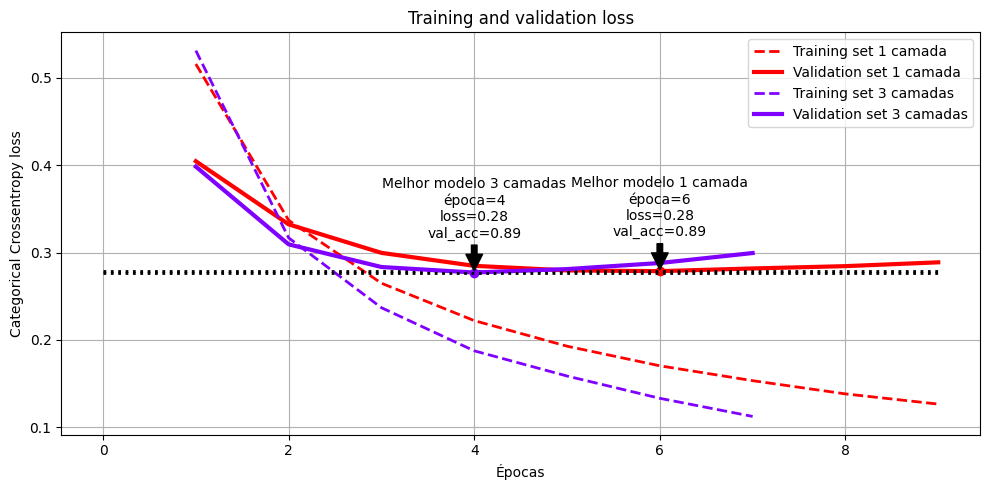

In [48]:
plot_train_val_loss(history_1layer, history_3layers,
                    history_labels=['1 camada', '3 camadas'],
                    save_path='./imgs/modelos_1e3_camadas.png')

Model 1
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     12500
         1.0       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Model 2
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     12500
         1.0       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



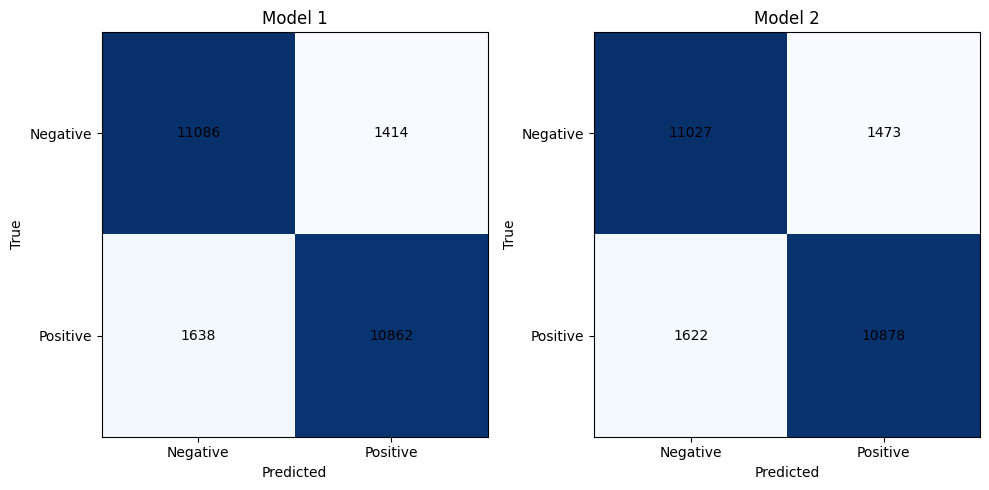

In [27]:
plot_stats_comparason([model_1layer, model_3layers], x_test, y_test)

#### Análise

Adicionar mais camadas não necessariamente melhora o desempenho do modelo. A adição de mais camadas pode aumentar a complexidade do modelo, o que pode levar ao *overfitting*.

Para o exercício de comparar o desempenho do modelo com uma ou três camadas `Dense`, é possível observar que o modelo com uma camada `Dense` obteve uma precisão de muito parecida com o modelo com uma camada `Dense`.

## 2. Use camadas com mais unidades ocultas ou menos unidades ocultas: 32 unidades, 64 unidades, e assim por diante.

In [28]:
# Testando modelo com 3 camadas da questão anterior, porém com 32 neurônios na camada oculta
architecture_sample1 = {
    'layers': [
        {'units': 16, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 32, 'activation': 'relu'},
        {'units': 1, 'activation': 'sigmoid'}
    ],
    'loss': 'binary_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [29]:
# Testando modelo com 3 camadas da questão anterior, porém com 64 neurônios na camada oculta
architecture_sample2 = {
    'layers': [
        {'units': 16, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 64, 'activation': 'relu'},
        {'units': 1, 'activation': 'sigmoid'}
    ],
    'loss': 'binary_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [30]:
# Testando arquitetura com 4 camadas e número de neurônios decrescente
architecture_sample3 = {
    'layers': [
        {'units': 64, 'activation': 'relu', 'input_shape': (10000,)},
        {'units': 32, 'activation': 'relu'},
        {'units': 16, 'activation': 'relu'},
        {'units': 1, 'activation': 'sigmoid'}
    ],
    'loss': 'binary_crossentropy',
    'optimizer': 'rmsprop',
    'metrics': ['accuracy']
}

In [31]:
model_sample1 = create_model(architecture_sample1)
model_sample2 = create_model(architecture_sample2)
model_sample3 = create_model(architecture_sample3)

c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# Fit model with sample 1
history_sample1 = fit_model(model_sample1, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6673 - loss: 0.6305 - val_accuracy: 0.8598 - val_loss: 0.4301
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8816 - loss: 0.3780 - val_accuracy: 0.8820 - val_loss: 0.3261
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9132 - loss: 0.2691 - val_accuracy: 0.8882 - val_loss: 0.2880
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9308 - loss: 0.2097 - val_accuracy: 0.8892 - val_loss: 0.2761
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9440 - loss: 0.1725 - val_accuracy: 0.8861 - val_loss: 0.2785
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9551 - loss: 0.1450 - val_accuracy: 0.8836 - val_loss: 0.2865
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9626 - loss: 0.1244 - val_accuracy: 0.8839 - val_loss: 0.2954


In [33]:
# Fit model with sample 2
history_sample2 = fit_model(model_sample2, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6664 - loss: 0.6187 - val_accuracy: 0.8611 - val_loss: 0.3965
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8833 - loss: 0.3447 - val_accuracy: 0.8798 - val_loss: 0.3122
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9175 - loss: 0.2418 - val_accuracy: 0.8899 - val_loss: 0.2776
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9307 - loss: 0.1975 - val_accuracy: 0.8898 - val_loss: 0.2747
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9485 - loss: 0.1561 - val_accuracy: 0.8865 - val_loss: 0.2827
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9564 - loss: 0.1326 - val_accuracy: 0.8855 - val_loss: 0.2956
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9684 - loss: 0.1062 - val_accuracy: 0.8844 - val_loss: 0.3112


In [34]:
# Fit model with sample 3
history_sample3 = fit_model(model_sample3, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6348 - loss: 0.6130 - val_accuracy: 0.8539 - val_loss: 0.3785
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8774 - loss: 0.3249 - val_accuracy: 0.8832 - val_loss: 0.2974
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9094 - loss: 0.2481 - val_accuracy: 0.8788 - val_loss: 0.3006
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9252 - loss: 0.2027 - val_accuracy: 0.8865 - val_loss: 0.2776
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9333 - loss: 0.1773 - val_accuracy: 0.8829 - val_loss: 0.2898
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9566 - loss: 0.1248 - val_accuracy: 0.8811 - val_loss: 0.3067
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9641 - loss: 0.1102 - val_accuracy: 0.8829 - val_loss: 0.3211


In [35]:
# Evaluate models (loss, accuracy)
model_sample1.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.8744 - loss: 0.3164


[0.3137547969818115, 0.8770400285720825]

In [36]:
# Evaluate models (loss, accuracy)
model_sample2.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.8719 - loss: 0.3360


[0.33360302448272705, 0.8745999932289124]

In [37]:
# Evaluate models (loss, accuracy)
model_sample3.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - accuracy: 0.8714 - loss: 0.3452


[0.34248340129852295, 0.8744800090789795]

In [50]:
# Get the lowest validation loss
min_val_loss_sample1 = np.min(history_sample1.history['val_accuracy'])
min_val_loss_sample2 = np.min(history_sample2.history['val_accuracy'])
min_val_loss_sample3 = np.min(history_sample3.history['val_accuracy'])

# Print the lowest validation loss of each sample model
print(f"Sample 1: {min_val_loss_sample1:.4f}")
print(f"Sample 2: {min_val_loss_sample2:.4f}")
print(f"Sample 3: {min_val_loss_sample3:.4f}")

Sample 1: 0.8598
Sample 2: 0.8611
Sample 3: 0.8539


#### Análise

Ao aumentar o número de unidades ocultas, não foi possível observar uma melhora significativa no desempenho do modelo

## 3. Use a função de perda `mse` em vez de `binary_crossentropy`.

Vamos usar a mesma arquitetura do primeiro modelo da questão 1 e comparar o desempenho do modelo com a função de perda `mse`.

In [38]:
architecture_mse = architecture_1layer.copy()
architecture_mse['loss'] = 'mse'

In [39]:
model_mse = create_model(architecture_mse)

In [40]:
history_mse = fit_model(model_mse, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6952 - loss: 0.2085 - val_accuracy: 0.8591 - val_loss: 0.1326
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8828 - loss: 0.1162 - val_accuracy: 0.8786 - val_loss: 0.1068
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9080 - loss: 0.0893 - val_accuracy: 0.8831 - val_loss: 0.0963
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9206 - loss: 0.0750 - val_accuracy: 0.8867 - val_loss: 0.0902
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9311 - loss: 0.0658 - val_accuracy: 0.8865 - val_loss: 0.0873
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9398 - loss: 0.0582 - val_accuracy: 0.8866 - val_loss: 0.0855
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9466 - loss: 0.0531 - val_accuracy: 0.8825 - val_loss: 0.0862
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9535 - loss: 0.0487 - val_accuracy: 0.8840 - 

Binary Crossentropy Model


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     12500
         1.0       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Mean Squared Error Model
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     12500
         1.0       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



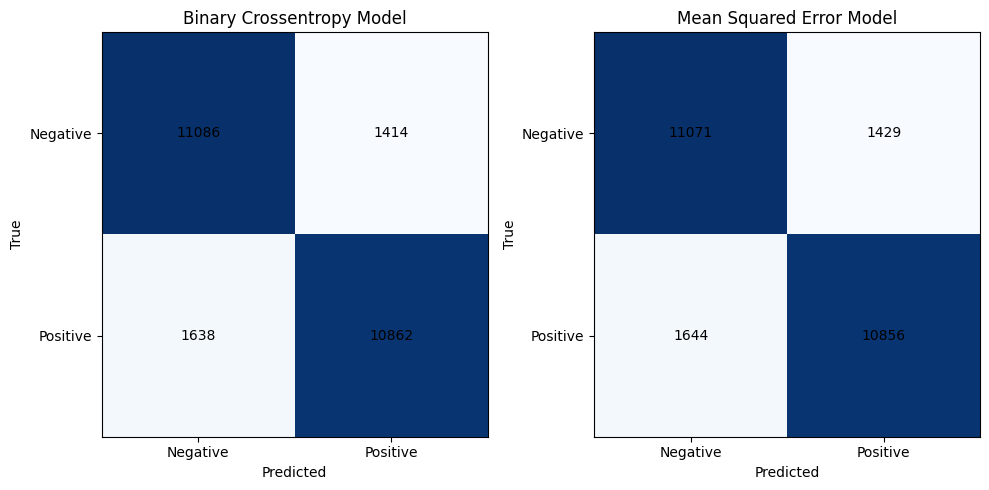

In [41]:
plot_stats_comparason([model_1layer, model_mse], x_test, y_test, model_names=['Binary Crossentropy Model', 'Mean Squared Error Model'])

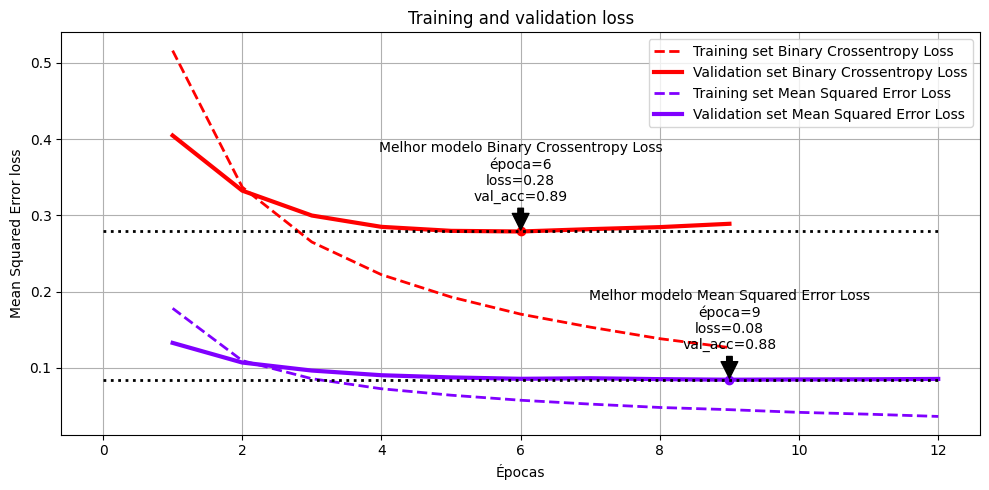

In [42]:
plot_train_val_loss(history_1layer, history_mse,
                    history_labels=['Binary Crossentropy Loss', 'Mean Squared Error Loss'],
                    loss_labels=['Binary Crossentropy', 'Mean Squared Error'],
                    save_path='./imgs/loss_comparison.png')

#### Análise

Como podemos observar no gráfico de perda x épocas, a função de perda `mse` apresenta um slope mais suave em comparação com a função de perda `binary_crossentropy`. Isso é ruim, pois um maior slope indica que a rede está aprendendo mais rápido. Um outro ponto é que a função de perda `mse` espera que a saída da rede seja um valor contínuo e entre (-inf, inf), enquanto a `binary_crossentropy` espera que a saída seja um valor entre (0, 1). Por isso, a função de perda `binary_crossentropy` é mais adequada para problemas de classificação binária.

Ainda é valido notar que as diferenças entre escalas entre as funções não significam que uma é melhor que a outra.

Por fim, a função `binary_crossentropy` foi capaz de convergir significativamente mais rápido que a função `mse`, porém não foi possível observar uma melhora significativa no desempenho do modelo no conjunto de dados de teste.

## 4. Use a ativação `tanh` (uma ativação que era popular nos primeiros dias das redes neurais) em vez de `relu`.

In [43]:
architecture_tanh = architecture_sample3.copy()
for layer in architecture_tanh['layers']:
    layer['activation'] = 'tanh'
architecture_tanh

{'layers': [{'units': 64, 'activation': 'tanh', 'input_shape': (10000,)},
  {'units': 32, 'activation': 'tanh'},
  {'units': 16, 'activation': 'tanh'},
  {'units': 1, 'activation': 'tanh'}],
 'loss': 'binary_crossentropy',
 'optimizer': 'rmsprop',
 'metrics': ['accuracy']}

In [44]:
model_tanh = create_model(architecture_tanh)

c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
history_tanh = fit_model(model_tanh, partial_x_train, partial_y_train, x_val, y_val, epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6514 - loss: 1.2056 - val_accuracy: 0.8561 - val_loss: 0.3779
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8737 - loss: 0.3900 - val_accuracy: 0.8260 - val_loss: 1.1732
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8870 - loss: 0.3766 - val_accuracy: 0.8813 - val_loss: 0.4611
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9275 - loss: 0.2587 - val_accuracy: 0.8815 - val_loss: 0.5394


ReLU Model
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     12500
         1.0       0.87      0.89      0.88     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Tanh Model
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87     12500
         1.0       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



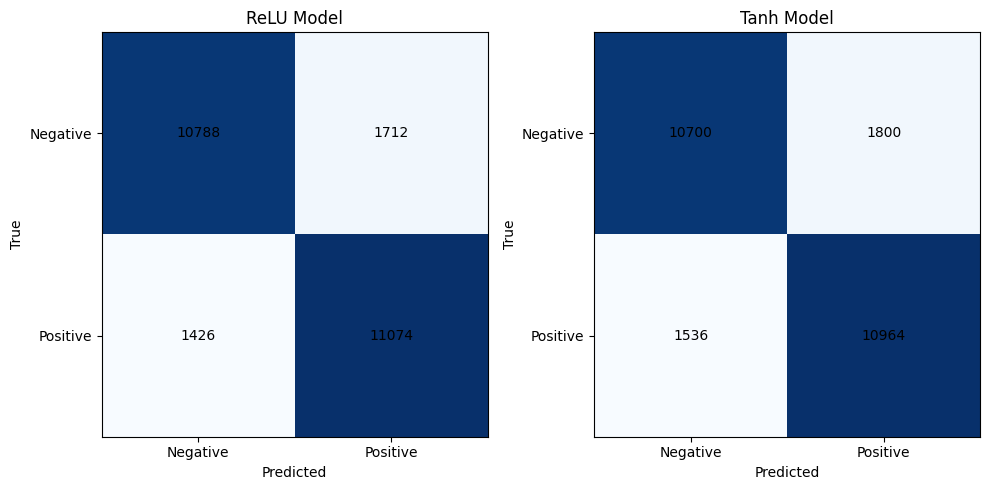

In [46]:
plot_stats_comparason([model_sample3, model_tanh], x_test, y_test, model_names=['ReLU Model', 'Tanh Model'])

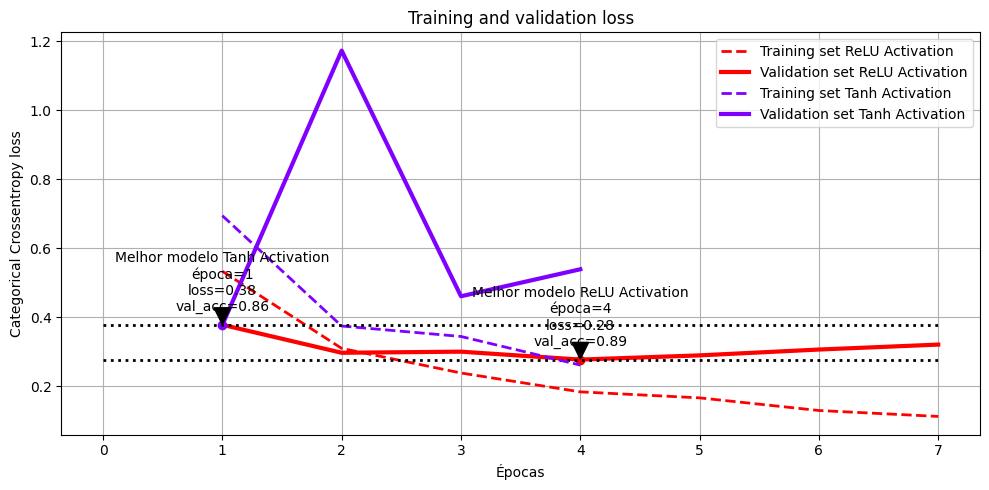

In [52]:
plot_train_val_loss(history_sample3, history_tanh,
                    history_labels=['ReLU Activation', 'Tanh Activation'],
                    save_path='./imgs/relu_tanh_comparison.png')

#### Análise

Como é possível observar no gráfico de perda x épocas, a função de ativação `tanh` gera uma perda não convexa, o que é ruim, pois a rede não consegue aprender de forma eficiente. A função de ativação `relu` se mostrou mais estável e eficiente para o problema de classificação binária. Porém, mais uma vez, não foi possível observar uma melhora significativa no desempenho do modelo no conjunto de dados de teste.